# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

Данный ноутбук посвящен первой части задания. Используется НЕ предобученная модель, являющаяся модификацией VGG16. В качестве основного источника вдохновения использовались: <br>
1) https://learningai.io/projects/2017/06/29/tiny-imagenet.html <br>
2) https://arxiv.org/pdf/1409.1556.pdf <br>
Модель обучалась на сайте kaggle.com с использованием GPU.

In [ ]:
# Обновим библиотеки до самых свежих
!pip install torch torchvision torchaudio --upgrade

In [1]:
import numpy as np
import torch
import torchvision
import tqdm
import sys
import random
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import albumentations
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm

# Заодно попросим матплотлиб отрисовывать старательно
%matplotlib inline
%config InlineBackend.figure_format="retina"

In [2]:
# Проверим что версия действительно стала свежее
torchvision.__version__

'0.11.1+cu102'

In [3]:
# Код из первого дз для уставки сида
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
set_random_seed(42)

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("We will use:", device)
try:
    # Мне просто интересно :)
    print("GPU model:", torch.cuda.get_device_name(0))
except:
    pass

We will use: cuda:0
GPU model: Tesla P100-PCIE-16GB


### Подготовка данных

In [6]:
# В силу особенностей библиотеки albumentations пришлось сделать такой "костыль"
class Transformer:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))["image"]

In [7]:
# В ссылках сверху предлагается ещё изменять сатурацию или оттенки, я так делать не буду, поскольку необходимое качество достигается и без них
train_transform = albumentations.Compose(
    [
        albumentations.RandomCrop(56, 56),
        albumentations.Resize(64, 64),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.augmentations.transforms.Normalize(),
        ToTensorV2(),
    ]
)
# Сентер кроп действительно улучшает качество без претрейна, в идеале
# Делать несколько кропов и брать majority vote как мне кажется
test_transform = albumentations.Compose(
     [
        albumentations.CenterCrop(56, 56),
        albumentations.Resize(64, 64),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.augmentations.transforms.Normalize(),
        ToTensorV2(),
    ]
)

In [8]:
# ВАРНУНГ: При перезапуске кода необходимо поменять path, потому что название датасета конкретно у вас скорее всего другое
train_path = r"../input/hwiad2/dataset/dataset/train"
train_dataset = datasets.ImageFolder(train_path, transform=Transformer(train_transform))
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)
test_path = r"../input/hwiad2/dataset/dataset/val"
test_dataset = datasets.ImageFolder(test_path, transform=Transformer(test_transform))
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=256, shuffle=True, num_workers=2
)

In [9]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [10]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
):
    # Передвинем модель на выбранный ускоритель
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    y_true = torch.tensor([], device=device)
    y_labels = torch.tensor([], device=device)
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for obj, ans in data_loader:
            # Туда же закинем объекты и ответы
            obj = obj.to(device)
            ans = ans.to(device)
            y_true = torch.cat((y_true, ans), 0)
            predicted = model(obj.float()).squeeze()
            loss = criterion(predicted, ans)
            # Обновим веса
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Обновим инфу
            prbar.set_description(
                f"Current loss: {round(loss.item(), 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            all_losses.append(loss.detach().item())
            y_pred_softmax = torch.log_softmax(predicted, dim=1)
            y_labels = torch.cat((y_labels, y_pred_softmax.argmax(dim=1)), 0)
            num_batches += 1
    y_true = y_true.to("cpu").numpy()
    y_labels = y_labels.to("cpu").numpy()
    metrics = {
        "loss": (total_loss / num_batches),
        "acc": accuracy_score(y_true, y_labels),
    }
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def test(model, data_loader, criterion, return_losses=False, device="cuda:0"):
    model = model.to(device).eval()
    all_losses = []
    y_true = torch.tensor([], device=device)
    y_labels = torch.tensor([], device=device)
    total_loss = 0
    num_batches = 0
    for obj, ans in data_loader:
        obj = obj.to(device)
        ans = ans.to(device)
        y_true = torch.cat((y_true, ans), 0)
        predicted = model(obj.float()).squeeze()
        loss = criterion(predicted, ans)
        total_loss += loss.item()
        all_losses.append(loss.detach().item())
        y_pred_softmax = torch.log_softmax(predicted, dim=1)
        y_labels = torch.cat((y_labels, y_pred_softmax.argmax(dim=1)), 0)
        num_batches += 1
    y_true = y_true.to("cpu").numpy()
    y_labels = y_labels.to("cpu").numpy()
    metrics = {
        "loss": (total_loss / num_batches),
        "acc": accuracy_score(y_true, y_labels),
    }
    if return_losses:
        return metrics, all_losses
    else:
        return metrics

In [11]:
def fit(
    model,
    epochs,
    train_data_loader,
    test_data_loader,
    optimizer,
    criterion,
    scheduler,
    desired_acc=1.0,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_train_accuracy = []
    epoch_test_losses = []
    epoch_test_accuracy = []
    for epoch in range(epochs):
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
            device=device,
        )
        print(
            "Mean loss:",
            round(train_metrics["loss"], 4),
            "Acc:",
            np.round(train_metrics["acc"], 4),
        )
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        epoch_train_accuracy.append(train_metrics["acc"])
        # Test step
        with torch.no_grad():
            test_metrics = test(
                model=model,
                data_loader=test_data_loader,
                criterion=criterion,
                device=device,
            )
        print(
            "Test mean loss:",
            round(test_metrics["loss"], 4),
            "Test acc:",
            np.round(test_metrics["acc"], 4),
        )
        epoch_test_losses.append(test_metrics["loss"])
        epoch_test_accuracy.append(test_metrics["acc"])
        scheduler.step(test_metrics["acc"])
        if test_metrics["acc"] >= desired_acc:
            break
    fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
    ax[0].plot(epoch_train_losses, label="Train")
    ax[0].plot(epoch_test_losses, label="Test")
    ax[0].set_title("Train/test loss evolution")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Mean loss")
    ax[0].grid()
    ax[0].legend()
    ax[1].plot(epoch_train_accuracy, label="Train")
    ax[1].plot(epoch_test_accuracy, label="Test")
    ax[1].set_title("Train/test accuracy evolution")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].grid()
    ax[1].legend()
    plt.show()

In [12]:
def predict(model, data_loader, criterion, device="cuda:0"):
    with torch.no_grad():
        model = model.to(device).eval()
        all_losses = []
        y_true = torch.tensor([], device=device)
        y_labels = torch.tensor([], device=device)
        for obj, ans in data_loader:
            obj = obj.to(device)
            ans = ans.to(device)
            y_true = torch.cat((y_true, ans), 0)
            predicted = model(obj.float()).squeeze()
            loss = criterion(predicted, ans)
            all_losses.append(loss.detach().item())
            y_pred_softmax = torch.log_softmax(predicted, dim=1)
            y_labels = torch.cat((y_labels, y_pred_softmax.argmax(dim=1)), 0)
        y_true = y_true.to("cpu").numpy()
        y_labels = y_labels.to("cpu").numpy()
        return all_losses, y_labels, y_true

### Обучение модели, запуски экспериментов

In [13]:
# Импортим только архитектуру сети. Импортировать архитектуры не запрещалось, претрейн специально указал False
vgg16_no_pretrain = torchvision.models.vgg16_bn(pretrained=False)
# Если есть желание, можно посмотреть архитектуру до 
# display(vgg16_no_pretrain)
# Вспомним что классов у нас 200 штук и задоно прооперируем последний слой:
vgg16_no_pretrain.classifier[6] = nn.Linear(4096, 200)
# Желающие могут посмотреть на итог операции:
# display(vgg16_no_pretrain)

In [14]:
# Я согласен, что для истории экспериментов хорошо бы иметь один гиганоутбук со всеми
# моделями по пути, но я напомню что сессия на kaggle.com ограничена 9 часами (гпу 39 в неделю, но любой ноутбук не более 9 подряд),
# после чего инстанс сбрасывается вместе с аутпутом. Можно сохранять и потом ручками склеивать ноутбуки, но это слишком неприятно.
# Надеюсь меня поймут и простят :)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    vgg16_no_pretrain.parameters(), lr=1e-2, weight_decay=1e-4, momentum=0.9
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.2)

Простой тест на проверку правильности написанного кода

In [15]:
all_losses, predicted_labels, true_labels = predict(
    vgg16_no_pretrain, test_dataloader, criterion, device
)
assert len(predicted_labels) == len(test_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

tests passed


Запустить обучение можно в ячейке ниже.

Train Epoch: 0


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 4.9977 Acc: 0.0228
Test mean loss: 4.6653 Test acc: 0.0448
Train Epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 4.4732 Acc: 0.0626
Test mean loss: 4.1961 Test acc: 0.0959
Train Epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 4.003 Acc: 0.1172
Test mean loss: 3.7873 Test acc: 0.1514
Train Epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 3.6705 Acc: 0.1693
Test mean loss: 3.66 Test acc: 0.1748
Train Epoch: 4


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 3.4093 Acc: 0.214
Test mean loss: 3.345 Test acc: 0.23
Train Epoch: 5


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 3.1933 Acc: 0.2527
Test mean loss: 3.0638 Test acc: 0.2803
Train Epoch: 6


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 3.0047 Acc: 0.2895
Test mean loss: 2.9894 Test acc: 0.296
Train Epoch: 7


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 2.8376 Acc: 0.3225
Test mean loss: 2.79 Test acc: 0.3368
Train Epoch: 8


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 2.6935 Acc: 0.3523
Test mean loss: 2.7268 Test acc: 0.351
Train Epoch: 9


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 2.5489 Acc: 0.3815
Test mean loss: 2.5858 Test acc: 0.3827
Train Epoch: 10


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 2.4302 Acc: 0.4081
Test mean loss: 2.6325 Test acc: 0.3727
Train Epoch: 11


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 2.3215 Acc: 0.4306
Test mean loss: 2.5501 Test acc: 0.3948
Train Epoch: 12


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 2.219 Acc: 0.4522
Test mean loss: 2.5406 Test acc: 0.4014
Train Epoch: 13


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 2.1175 Acc: 0.474
Test mean loss: 2.4571 Test acc: 0.417
Train Epoch: 14


  0%|          | 0/1563 [00:00<?, ?it/s]

Mean loss: 2.0331 Acc: 0.4915
Test mean loss: 2.3377 Test acc: 0.447


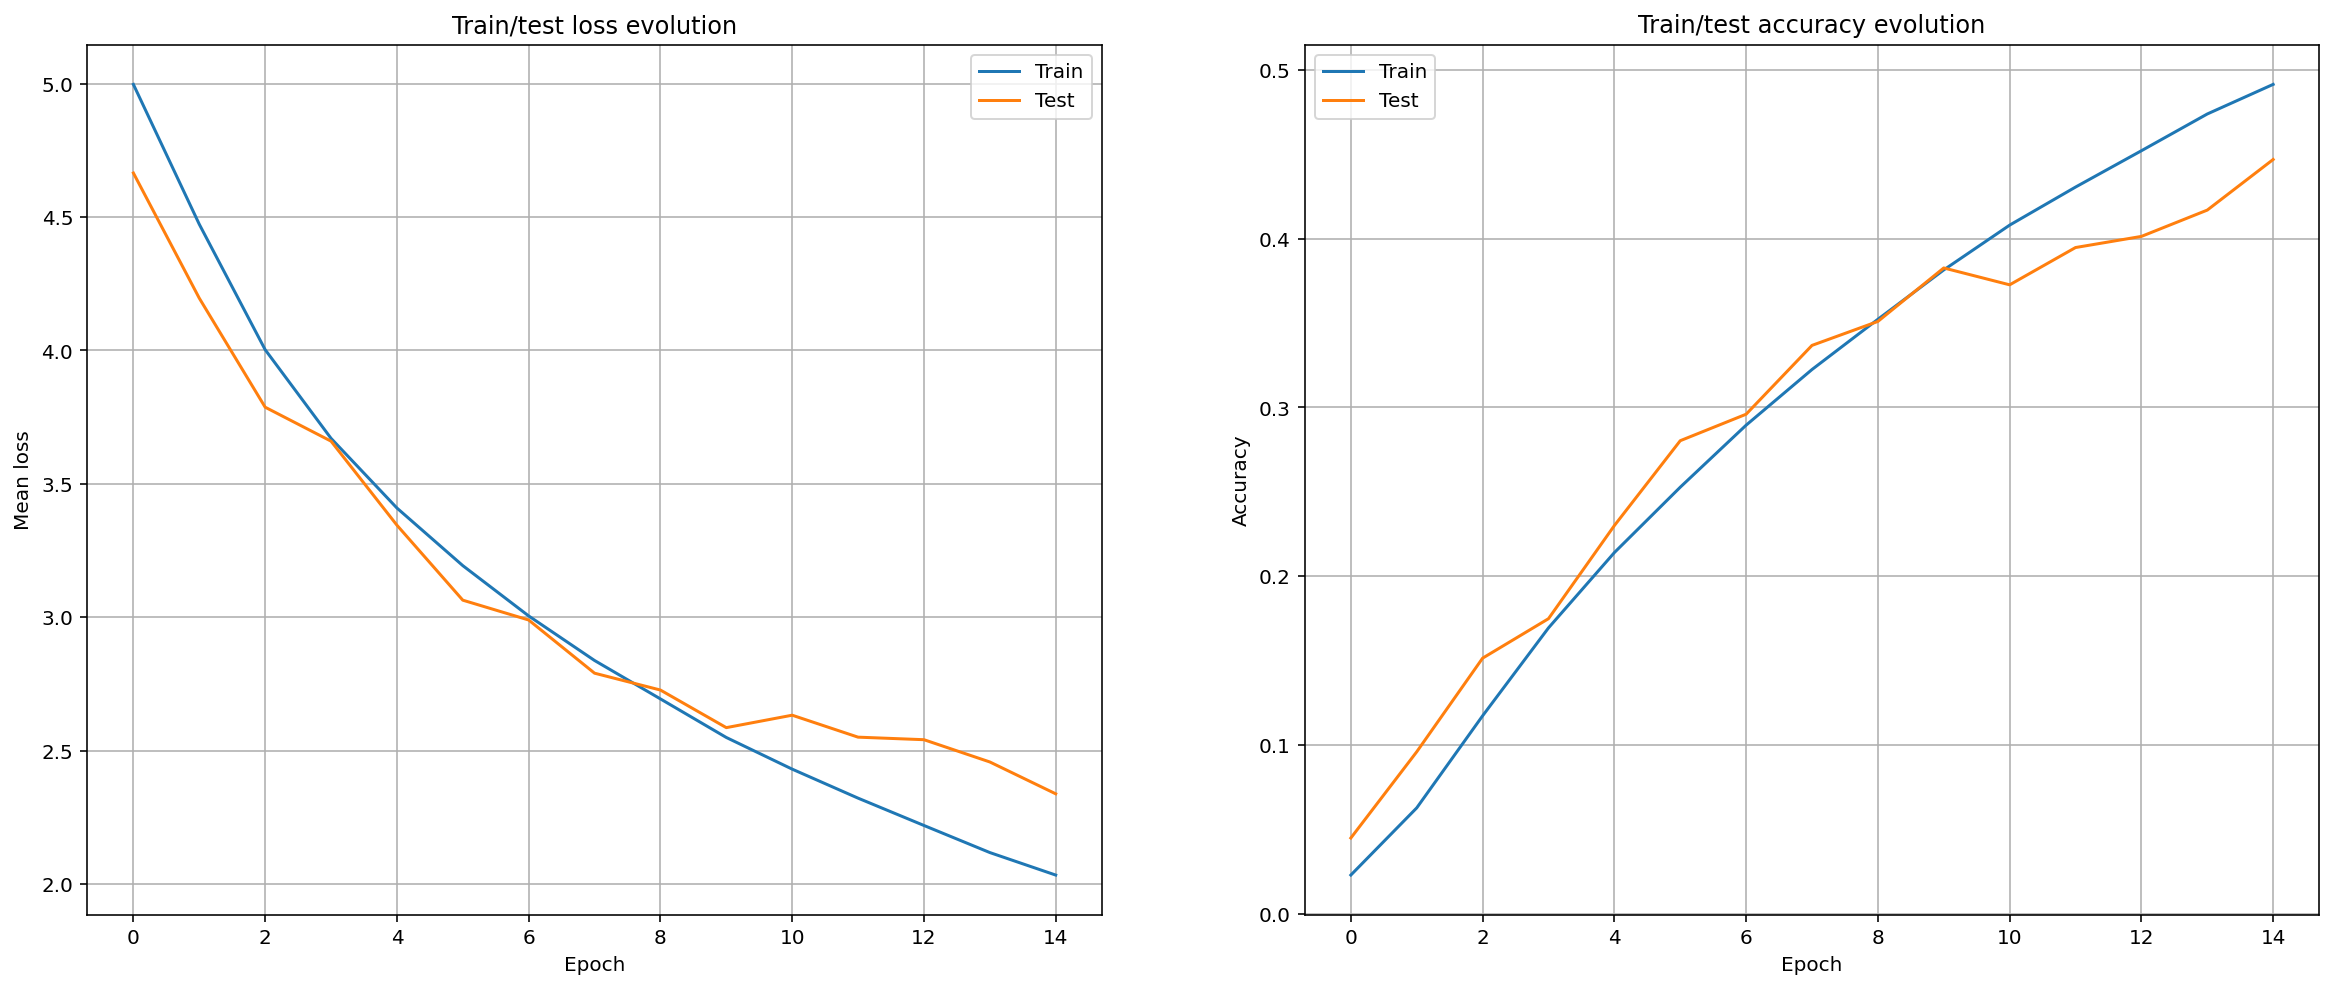

In [16]:
fit(
    vgg16_no_pretrain,
    1000,  # На всякий случай, вдруг desired недостижим
    train_dataloader,
    test_dataloader,
    optimizer,
    criterion,
    scheduler,
    desired_acc=0.44,
    device=device,
)

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [17]:
def evaluate(model, data_loader, criterion, device="cuda:0"):
    _, pred, true = predict(model, data_loader, criterion, device)
    return accuracy_score(true, pred)

In [18]:
all_losses, predicted_labels, true_labels = predict(
    vgg16_no_pretrain, test_dataloader, criterion, device
)
assert len(predicted_labels) == len(test_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Оценка за это задание составит {min(10, 10 * accuracy / 0.44)} баллов")

Оценка за это задание составит 10 баллов


In [19]:
print("Accuracy:", evaluate(vgg16_no_pretrain, test_dataloader, criterion, device))

Accuracy: 0.4471


### Отчёт об экспериментах 

Хорошо конечно сидеть и тратить дни на то, чтобы перебрать самовыдуманные архитектуры, но мне показалось более интересным потратить день и почитать тонну статеек и блогпостов про наш датасет. Фан фэкт: бОльшая часть "крутых" машинлернеров с разных сайтов выбивали на претрейне 0.6-0.7 и говорили вау как круто. Спустя некое очень немалое время удалось найти изложенное выше. Сначала я честно имплементировал то, что предлагалось в блогпосте выше. Это VGG16 с вырезанным последним блоком. К сожалению, то ли я что-то недокодил, то ли автор делал что-то ещё, но выше 0.39 качество не поднималось. Тогда я увидел на сайте пайторча существование того же VGG16, но с батчнормами. Как известно из первой дз, они обычно делают две вещи: ускоряют обучение и уменьшают переобучение. Вырезав тот же последний блок, я поставил по новой и увидел 0.43, что гораздо приятнее, но все еще не 10. Окей, поверим советам из гугла (они есть и выше и вообще много где ещё) и добавим сентер кроп, также я решил дать возможность VGG16 поработать без операций по удалению последнего слоя и бинго, вот они заветные овер 0.44. По пути я ещё пробовал сменить сгд на адама, с адамом сеть учится гораздо быстрее, из-за чего у меня он доводил до переобучения за несколько эпох даже с lr=1e-5. Попытки сделать StepLR и уменьшать lr каждый шаг ни к чему не привели, но тут, вероятно, я недостаточно много времени потратил на тюнинг. Сгд как таковой гораздо легче в плане подбора параметров и в принципе позволил достичь желаемого примерно за час, поэтому решил оставить его.